In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation,rc
from scipy.integrate import odeint
from scipy import optimize as opt

width = 12
height = 12
from IPython.display import HTML
rc('animation', html='html5')

In [3]:
def inital_value_wave(J, M, x_interval, t_interval, f, g, s=1):
    def interperet_interval(interval):
        if isinstance(interval, ( int, float )):
            a, b = 0, interval
        else:
            try:
                a, b = interval
            except:
                raise ValueError("interval should be a 2 d tuple (or an int)")
        return a,b
    a, b = interperet_interval(x_interval)
    c, d = interperet_interval(t_interval)
    x_array = np.linspace(a, b, J+1)
    del_x = (b-a)/float(J)
    del_t = (d-c)/float(M)
        
    lam = (s*del_t)/del_x
    A = np.diag([2*(1-(lam**2))]*(J-1)) + np.diag([lam**2]*(J-2), k=-1) + np.diag([lam**2]*(J-2), k=1)
    U_0 = f(x_array) #F of x values from x_0 to x_J
    U_1 = U_0[1:-1] + g(x_array[1:-1]) * del_t+((lam**2)/2.) * (U_0[0:-2]-2*U_0[1:-1]+U_0[2:])
    U_0 = U_0[1:-1] #F of x values from x_1 to x_J-1
    U = [U_0, U_1]
    for m in range(M-1):
        U_M = np.dot(A, U_1) - U_0
        U.append(U_M)
        U_0 = U_1
        U_1 = U_M
    U = np.vstack(U)
    U = np.hstack((np.array([[f(a)]]*U.shape[0]),U,(np.array([[f(b)]]*U.shape[0]))))
    return x_array, U

In [4]:
def actual_solution(x,t):
    return np.sin(2*np.pi*x) * np.cos(2*np.pi*t)

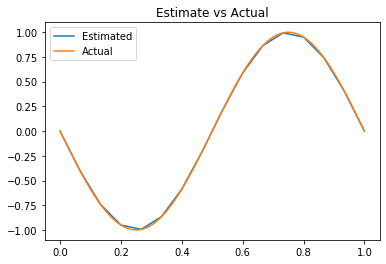

In [26]:
J, M = 15, 5
a, b = 0, 1
t = .5
s = 1
f = lambda x: np.sin(2*np.pi*x)
g = lambda x: 0.0 * x

X, sol = inital_value_wave(J, M, (0,1), .5, f, g)

sol_par = sol[-1]

plt.plot(X, sol_par, label='Estimated')
plt.plot(np.linspace(0, 1, 100), actual_solution(np.linspace(0, 1, 100), .5), label='Actual')
plt.title("Estimate vs Actual")
plt.legend()
plt.show()

In [6]:
def animate_func(X, T, solutions, t_start=0, speed=None, ylim=None):
    if ylim is None:
        ylim = (-T, T)
    x = X
    y = solutions
    fig = plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, xlim=(X[0],X[-1]), ylim=ylim)
    #plt.axes(xlim=(-12,12), ylim=(0,1))
    line, = plt.plot([], [], '-', lw=2) 
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    #line, = plt.plot([], [])
    def animate(i):
        interval = (1./float(len(y)))
        line.set_data(x, y[i])
        time_text.set_text('time = %.3f' % (i*T/float(len(y))))
        return line, time_text, 
    if speed is not None:
        anim = animation.FuncAnimation(fig, animate, frames=len(y), interval=speed, blit=True)
    else:
        anim = animation.FuncAnimation(fig, animate, frames=len(y), interval=50, blit=True)
    plt.close(anim._fig)
    return anim
    #a = animation.FuncAnimation(f, animate, frames=y.size, interval=20)
    #plt.show()

In [7]:
f = lambda m: lambda x: .2 * np.exp(-1*m**2*(x-.5)**2)
g = lambda m: lambda x: -.4 * m**2 * (x-.5) * np.exp((-1*m**2)*(x-.5)**2)

In [8]:
m=20
J=200

X, Y = inital_value_wave(J, 220, (0,1), 1, f(m), g(m)) #220 sub intervals in time
animate_func(X, 1, Y, speed=20)


## Example where stability condition is not satisfyed

In [9]:
X, Y = inital_value_wave(J, 180, (0,1), 1, f(m), g(m)) #180 sub intervals in time
animate_func(X, 1, Y, speed=20)

# Modeling Wave Interference

In [17]:
m = 20
f = lambda m: lambda x: (.2 * np.exp(-1*m**2*(x-.75)**2) * (x > .5)) + .2 * np.exp(-1*m**2*(x-.25)**2) * (x < .5)
g = lambda m: lambda x: ((.4 * m**2 * (x-.25) * np.exp((-1*m**2)*(x-.25)**2)) * (x < .5) + (-.4 * m**2 * (x-.75) * np.exp((-1*m**2)*(x-.75)**2)) * (x > .5))
J = 200
M = 440

X, Y = inital_value_wave(J, M, (0,1), 2, f(m), g(m)) #180 sub intervals in time
animate_func(X, 2, Y, speed=20)

In [16]:
m = 20
J = 200
M = 220

f = lambda m: lambda x: (.2 * np.exp(-1*m**2*(x-.75)**2) * (x > .5)) + (-.2 * np.exp(-1*m**2*(x-.25)**2) * (x < .5)) 
g = lambda m: lambda x: ((-.4 * m**2 * (x-.25) * np.exp((-1*m**2)*(x-.25)**2)) * (x < .5) + (-.4 * m**2 * (x-.75) * np.exp((-1*m**2)*(x-.75)**2)) * (x > .5))

X, Y = inital_value_wave(J, M, (0,1), .25, f(m), g(m)) #180 sub intervals in time
animate_func(X, 2, Y, speed=12)

# Non-linear perturbation

In [12]:
def crank_nicol(f, J, M, x_interval, t_interval, nu):
    def interperet_interval(interval):
        if isinstance(interval, ( int, float )):
            a, b = 0, interval
        else:
            try:
                a, b = interval
            except:
                raise ValueError("interval should be a 2 d tuple (or an int)")
        return a,b
    
    a, b = interperet_interval(x_interval)
    c, d = interperet_interval(t_interval)
    x_array = np.linspace(a, b, J+1)
    del_x = (b-a)/float(J)
    del_t = (d-c)/float(M)

    
    k_1 = del_t / (4*del_x)
    k_2 = del_t / (2*del_x**2)
    
    U = [f(x_array)]
    U_0 = U[0]
    
    def clac_ph(x):
        ph = np.zeros(U_0.shape)
        ph[1:-1]= (x[1:-1] - U_0[1:-1] - k_1*((s-x[1:-1])*(x[2:]-x[:-2]) + 
                  (s-U_0[1:-1])*(U_0[2:] - U_0[:-2])) - k_2*((x[2:]-2*x[1:-1]+x[:-2])+ 
                  (U_0[2:]-2*U_0[1:-1]+U_0[:-2])))
        
        ph[0] = x[0]-U_0[0]
        ph[-1] = x[-1]-U_0[-1]
        
        return ph
    
    for i in range(M):
        U_0 = opt.fsolve(clac_ph, np.zeros(J+1))
        U.append(U_0)
        
    U = np.vstack(U)
    return x_array, U

In [21]:
delta = 0.
u_minus = 5.
u_plus = 1.
a = (u_minus - u_plus)/2.
s = (u_minus+u_plus)/2.
nu = 1.
x_interval = (-20, 20)
t_interval = (0., 1.0)
J = 150
M = 350

u_hat = lambda x: s-a * np.tanh(a*x/float(2*nu) + delta)
v = lambda x: 3.5 * (np.sin(3*x)+1) * (1/np.sqrt(2*np.pi)) * np.exp(-x**2/2)
f = lambda x: u_hat(x) + v(x)

X, Y = crank_nicol(f, J, M, x_interval, t_interval, nu)
animate_func(X, 2, Y, speed=25, ylim=(0,6))